# Compare Hankel and Fourier Transforms #

This will compare the forward and inverse transforms for both Hankel and Fourier by either computing partial derivatives of solving a parital differential equation.

This notebook focuses on the Laplacian operator in the case of radial symmetry. 

Consider two functions $f(r)$ and $g(r)$ that are related by the following differential operator,
$$
g(r) = \nabla^2 f(r) 
= \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial f}{\partial r} \right)
$$
There are two cases that will be considered:
1. Given $f(r)$, compute the Laplacian to obtain $g(r)$
2. Given $g(r)$, invert the Laplacian to obtain $f(r)$

This is easily done in two-dimensions using the Fast Fourier Transform (FFT) but one advantage of the Hankel transform is that we only have a one-dimensional transform.

In [1]:
# Import Libraries

import numpy as np                                                        # Numpy
from scipy.fftpack import fft2, ifft2                                     # Fourier
from hankel import HankelTransform                                        # Hankel
from scipy.interpolate import InterpolatedUnivariateSpline as spline      # Splines
import matplotlib.pyplot as plt                                           # Plotting
%matplotlib inline

In [2]:
# Parameters

L     = 10.0
N     = 128
b0    = 1.0

In [3]:
# 1D Grid for Hankel

dr = L/N
rh = np.linspace(dr/2,L-dr/2,N)

# 2D Grid for Fourier

rf = np.linspace(-L+dr/2,L-dr/2,2*N) 
xx,yy = np.meshgrid(rf,rf)
rr = np.sqrt(xx**2 + yy**2)
theta = np.arctan2(yy, xx)

In [4]:
# Fourier Spectral grid

kf = np.pi/L*np.hstack([range(0,N+1), range(-N+1,0)])
kk,ll = np.meshgrid(kf,kf)

dk   = kf[1]
kmax = kf[N]

# Hankel Spectral grid
# Pick the smallest wavenumber to be the same as in the Fourier case
# Also, pick the largest wavenumber to be 2.5 times the maximum
# The number of steps is the same
# Not sure why but this seems to work
kh = np.logspace(np.log10(dk), np.log10(2.5*kmax),N)
#kh2 = np.logspace(-0.5,2,N)      

## 1) Define Sample Functions ##

We define the two functions
$$
f = e^{-r^2}
\quad \mbox{ and } \quad
g = 4 e^{-r^2} (r^2 - 1).
$$
It is easy to verify that they are related by the Laplacian operator, 
$$
\nabla^2 f(r) 
= \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial f}{\partial r} \right) = g.
$$

In [5]:
# Define f(r) to be Gaussian

f = lambda r: np.exp(-r**2)

# Define g(r) to be the Laplacian of the Gaussian function

g = lambda r: 4.0*np.exp(-r**2)*(r**2 - 1.0)

In [6]:
# Evaluate functions in 2D

ff, gf = f(rr), g(rr)

# Evaluate functions in 1D

fh, gh = f(rh), g(rh)

In [7]:
# Spectral Fourier operators

K2f         = -(kk**2 + ll**2)

K2finv      = -1.0/(kk**2 + ll**2)
K2finv[0,0] = 0.0

# Spectral Hankel operators

K2h      = -(kh**2)
K2hinv   = -1.0/kh**2

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide


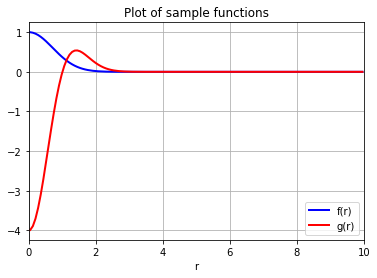

In [8]:
plt.plot(rh,fh,'-b',         linewidth=2,label='f(r)')
plt.plot(rh,gh,'-r',         linewidth=2,label='g(r)')
plt.title('Plot of sample functions')
plt.legend(loc='lower right')
plt.grid('on')
plt.xlim([0,L])
plt.xlabel('r')
#plt.show()
plt.savefig('figure1')
#

## 2) Example 1: Compute Laplacian ##

We use the 1D Hankel (or 2D Fourier) transform to compute the Laplacian in three steps:

a. Compute the Forward Transform
    $$
    \mathcal{H}[f(r)] = \hat f(k)
    $$
b. Differentiate in Spectral space
    $$
    \hat g(k) = - k^2 \hat f(k)
    $$
c. Compute the Inverse Transform
    $$
    g(r) = \mathcal{H}^{-1} [\hat g(k)]
    $$

### a) Forward Transforms ###

In [9]:
# Compute Hankel transform

ht = HankelTransform(nu=0,N=1000,h=0.0025)      # Create the Hankel Transform 
fhhat = ht.transform(f,kh,ret_err=False)        # Return the transform of f at k.

# Compute Fourier Transform

ffhat = fft2(ff)

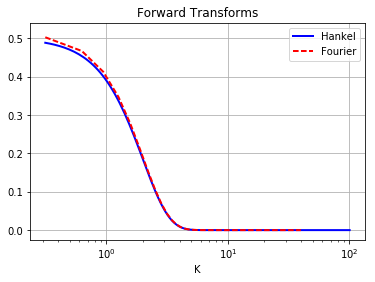

In [10]:
# Plot the Forward Transforms

plt.semilogx(kh,fhhat,'-b',linewidth=2, label='Hankel')
plt.semilogx(kf[0:N],np.absolute(ffhat[0,0:N])/1e3,'--r',linewidth=2, label='Fourier')
#plt.semilogx(kf[0:N],ffhat[0,0:N].real/1e3,'--r',linewidth=2, label='Fourier')
#plt.xlim([kh[0],kh[-1]])
#plt.ylim([-0.1, 0.6])
plt.grid('on')
plt.xlabel('K')
plt.legend(loc='best')
plt.title('Forward Transforms')
#plt.show()
plt.savefig('figure2.png')

### b) Transform of Laplacian ##

In [11]:
# Differentiate in spectral space

Lapfhhat = K2h*fhhat

# Differentiate in spectral space

Lapffhat = K2f*ffhat

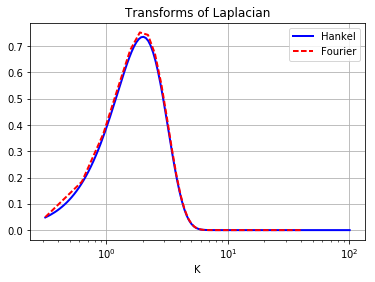

In [13]:
# Plot the Transforms of Laplacian

plt.semilogx(kh,-Lapfhhat,'-b',linewidth=2, label='Hankel')
plt.semilogx(kf[0:N],np.absolute(Lapffhat[0,0:N])/1e3,'--r',linewidth=2, label='Fourier')
#plt.semilogx(kf[0:N],Lapffhat[0,0:N].real/1e3,'--r',linewidth=2, label='Fourier')
#plt.xlim([kh[0],kh[-1]])
#plt.ylim([-0.1, 0.6])
plt.grid('on')
plt.xlabel('K')
plt.legend(loc='best')
plt.title('Transforms of Laplacian')
#plt.show()
plt.savefig('figure3.png')

### c) Inverse Transforms ##

In [14]:
# Build a spline to approximate the transform

Lapfhhat_sp = spline(kh, Lapfhhat)
Lapfh = ht.transform(Lapfhhat_sp, rh, False, inverse=True)

# Invert Fourier

Lapff = ifft2(Lapffhat).real

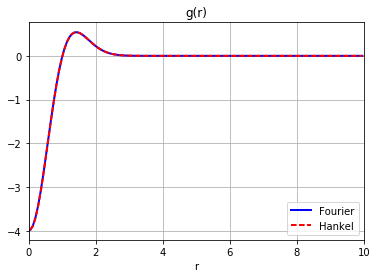

In [15]:
# Plot Laplacian of f

plt.plot(rf,Lapff[N,:],'-b',linewidth=2,label='Fourier')
plt.plot(rh,Lapfh,     '--r',linewidth=2,label='Hankel')
#plt.plot(rf,gf[N,:],ls='--',       linewidth=2,label='Exact')
plt.xlim([0,L])
plt.xlabel('r')
plt.grid('on')
plt.title('g(r)')
plt.legend(loc='best')
#plt.show()
plt.savefig('figure4.png')

### d) Absolute Errors in Method ##

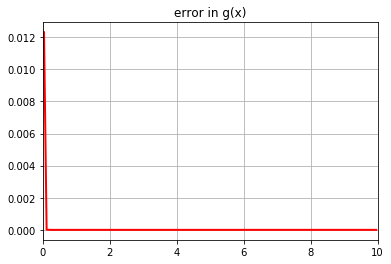

In [16]:
# Plot error in Laplacian of f

#plt.plot(rf,Lapff[N,:]-gf[N,:],'-b', linewidth=2,label='Fourier')
plt.plot(rh,Lapfh-gh,          '-r',linewidth=2,label='Hankel')
plt.title('error in g(x)')
plt.xlim([0, L])
plt.grid('on')
plt.show()

## 3) Example 2: Invert Laplacian ##

We use the 1D Hankel (or 2D Fourier) transform to compute the Laplacian in three steps:
1. Compute the Forward Transform
    $$
    \mathcal{H}[g(r)] = \hat g(k)
    $$
2. Differentiate in Spectral space
    $$
    \hat f(k) = - \frac{1}{k^2} \hat g(k)
    $$
3. Compute the Inverse Transform
    $$
    f(r) = \mathcal{H}^{-1} [\hat f(k)]
    $$

### a) Forward Hankel Transform ###

In [56]:
# Compute Hankel transform

ghhat = ht.transform(g,kh,ret_err=False)        # Return the transform of g at k.

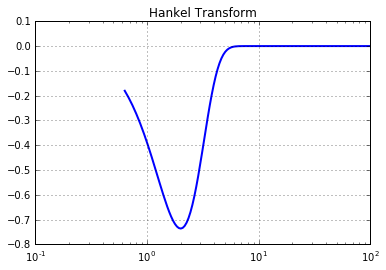

In [57]:
# Plot the transform and the error

plt.semilogx(kh,ghhat,linewidth=2)
plt.xlim([1e-1,1e2])
plt.grid('on')
plt.title('Hankel Transform')
plt.show()

### b) Forward Fourier Transform ###

In [58]:
# Compute Fourier Transform

gfhat = fft2(gf)

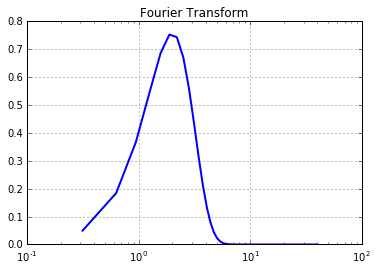

In [59]:
# Plot the transform and the error

plt.semilogx(kf[0:N],np.absolute(gfhat[0,0:N])/1e3,linewidth=2)
plt.xlim([1e-1,1e2])
plt.grid('on')
plt.title('Fourier Transform')
plt.show()

### c) Inverse Hankel Transform ###

In [60]:
# Invert Laplacian in Spectral space

iLapghhat = K2hinv*ghhat

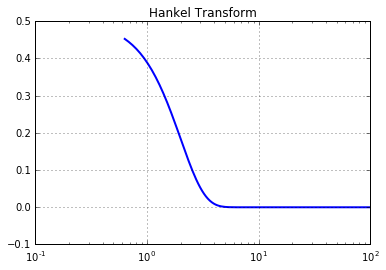

In [61]:
# Plot the transform 

plt.semilogx(kh,iLapghhat,linewidth=2)
plt.xlim([1e-1,1e2])
plt.grid('on')
plt.title('Hankel Transform')
plt.show()

In [62]:
# Interpolate onto a spline

iLapghhat_sp = spline(kh, iLapghhat)
iLapgh = ht.transform(iLapghhat_sp, rh, False, inverse=True)

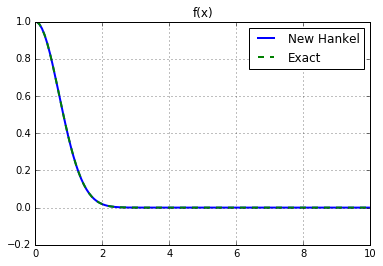

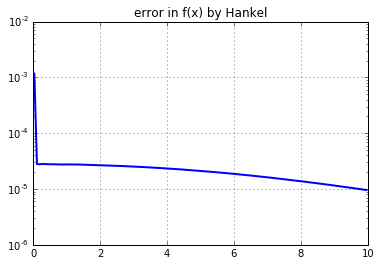

In [63]:
# Compare numerical and exact functions

plt.plot(rh,iLapgh,linewidth=2,label='New Hankel')
plt.plot(rh,fh,ls='--',   linewidth=2,label='Exact')
plt.grid('on')
plt.title('f(x)')
plt.legend(loc='best')
plt.show()

plt.plot(rh,np.abs(iLapgh-fh),linewidth=2,label='Error Hankel')
plt.title('error in f(x) by Hankel')
plt.grid('on')
plt.yscale('log')
plt.show()

### d) Inverse Fourier Transform ###

In [64]:
# Differentiate in spectral space

iLapgfhat = K2finv*gfhat

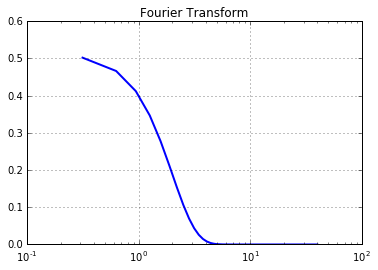

In [65]:
# Plot the transform

plt.semilogx(kf[0:N],np.absolute(iLapgfhat[0,0:N])/1e3,linewidth=2)
plt.xlim([1e-1,1e2])
plt.grid('on')
plt.title('Fourier Transform')
plt.show()

In [66]:
# Invert Fourier

iLapgf = ifft2(iLapgfhat).real

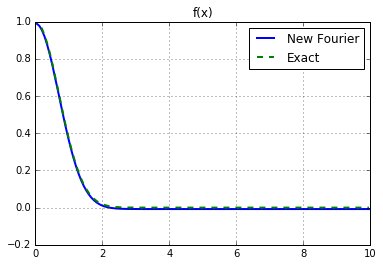

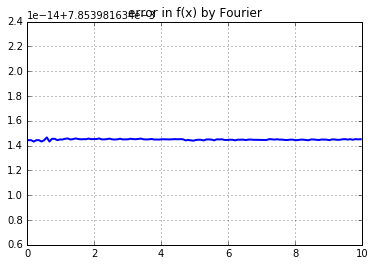

In [67]:
# Plot inverse Laplacian of g

plt.plot(rf,iLapgf[N,:],linewidth=2,label='New Fourier')
plt.plot(rf,ff[N,:],ls='--',       linewidth=2,label='Exact')
plt.xlim([0,L])
plt.grid('on')
plt.title('f(x)')
plt.legend(loc='best')
plt.show()

plt.plot(rf,np.abs(iLapgf[N,:]-ff[N,:]),linewidth=2,label='Error Fourier')
plt.title('error in f(x) by Fourier')
plt.xlim([0, L])
plt.grid('on')
plt.show()

### e) Compare spectra ###

This compares the spectra directly.


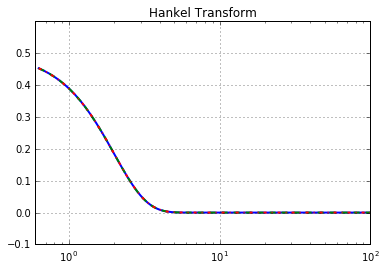

In [68]:
plt.semilogx(kh,fhhat,linewidth=2)
plt.semilogx(kh,iLapghhat,ls='--',linewidth=2)
plt.semilogx(kh,iLapghhat_sp(kh),ls='-.',linewidth=2)
plt.xlim([0.6,1e2])
plt.ylim([-0.1, 0.6])
plt.grid('on')
plt.title('Hankel Transform')
plt.show()

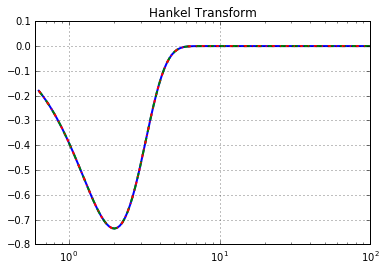

In [69]:
plt.semilogx(kh,ghhat,linewidth=2)
plt.semilogx(kh,Lapfhhat,ls='--',linewidth=2)
plt.semilogx(kh,Lapfhhat_sp(kh),ls='-.',linewidth=2)
plt.xlim([0.6,1e2])
plt.grid('on')
plt.title('Hankel Transform')
plt.show()

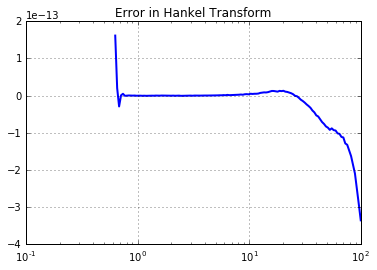

In [70]:
plt.semilogx(kh,ghhat-Lapfhhat,linewidth=2)
plt.xlim([1e-1,1e2])
plt.grid('on')
plt.title('Error in Hankel Transform')
plt.show()